## IMPORT LIBRARES AND PACKAGES

In [1]:
import tensorflow.keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2

from PIL import Image
from scipy import stats

from tensorflow.keras.utils import to_categorical

## [1] DATA PREPARATION

Setup data directory

In [2]:
IMAGE_DIRECTORY = "./data-1/cohn-kanade-images/"
DATA_LABEL_DIRECTORY = "./data-1/data_labels.csv"

#### Load Label Dataset

In [3]:
df = pd.read_csv(DATA_LABEL_DIRECTORY)

Explore head

In [4]:
df.head(5)

,subject,sequence,image_index,filepath,file_prefix,AU17,AU1,AU2,AU25,AU27,...,AU7,AU23,AU24,AU6,AU12,AU15,AU14,AU11,AU26,high_level_emotion
0,S005,1,11,./cohn-kanade-images/S005/001/S005_001_0000001...,S005_001_00000011,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
1,S010,1,14,./cohn-kanade-images/S010/001/S010_001_0000001...,S010_001_00000014,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,negative
2,S010,2,14,./cohn-kanade-images/S010/002/S010_002_0000001...,S010_002_00000014,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,surprise
3,S010,3,18,./cohn-kanade-images/S010/003/S010_003_0000001...,S010_003_00000018,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
4,S010,4,19,./cohn-kanade-images/S010/004/S010_004_0000001...,S010_004_00000019,1,0,0,0,0,...,1,1,1,0,0,0,0,0,0,negative


Explore Tail

In [5]:
df.tail(5)

,subject,sequence,image_index,filepath,file_prefix,AU17,AU1,AU2,AU25,AU27,...,AU7,AU23,AU24,AU6,AU12,AU15,AU14,AU11,AU26,high_level_emotion
555,S506,4,38,./cohn-kanade-images/S506/004/S506_004_0000003...,S506_004_00000038,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,negative
556,S506,6,42,./cohn-kanade-images/S506/006/S506_006_0000004...,S506_006_00000042,1,1,1,0,0,...,0,0,0,0,0,1,0,0,1,negative
557,S895,2,7,./cohn-kanade-images/S895/002/S895_002_0000000...,S895_002_00000007,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,negative
558,S999,1,18,./cohn-kanade-images/S999/001/S999_001_0000001...,S999_001_00000018,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,negative
559,S999,3,55,./cohn-kanade-images/S999/003/S999_003_0000005...,S999_003_00000055,0,1,1,1,0,...,0,0,0,0,0,0,1,0,0,negative


Convert Emotion Label To Numeric

In [6]:
target_mapping = {'negative': 0, 'positive': 1, 'surprise': 2}
df['high_level_emotion_num'] = df['high_level_emotion'].map(target_mapping)

#### 1.1 DATA INTEGRITY CHECKING

Check Duplicate

In [7]:
print('Number of duplicated rows:', df.duplicated().sum())

Number of duplicated rows: 0


Check Nan Value

In [8]:
print('Number of Nan value rows:\n', df.isnull().sum())

Number of Nan value rows:
 subject                   0
sequence                  0
image_index               0
filepath                  0
file_prefix               0
AU17                      0
AU1                       0
AU2                       0
AU25                      0
AU27                      0
AU4                       0
AU7                       0
AU23                      0
AU24                      0
AU6                       0
AU12                      0
AU15                      0
AU14                      0
AU11                      0
AU26                      0
high_level_emotion        0
high_level_emotion_num    0
dtype: int64


Check Data Overall 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   subject                 560 non-null    object
 1   sequence                560 non-null    int64 
 2   image_index             560 non-null    int64 
 3   filepath                560 non-null    object
 4   file_prefix             560 non-null    object
 5   AU17                    560 non-null    int64 
 6   AU1                     560 non-null    int64 
 7   AU2                     560 non-null    int64 
 8   AU25                    560 non-null    int64 
 9   AU27                    560 non-null    int64 
 10  AU4                     560 non-null    int64 
 11  AU7                     560 non-null    int64 
 12  AU23                    560 non-null    int64 
 13  AU24                    560 non-null    int64 
 14  AU6                     560 non-null    int64 
 15  AU12  

## [2] EXPLORATORY DATA ANALYSIS

2.1 Check Label Count

/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_99992/2055809110.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=target_value_counts.index, y=target_value_counts.values, palette='hls',)


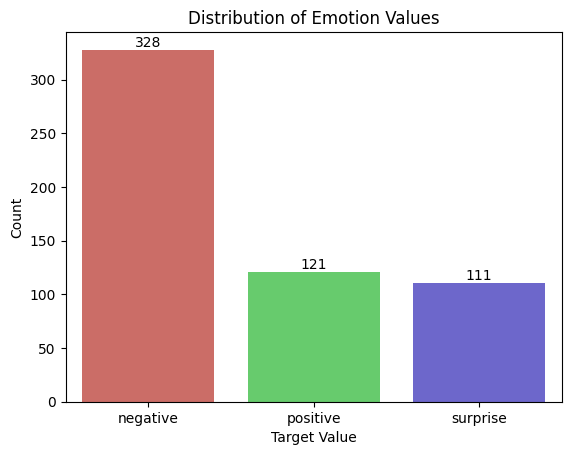

In [10]:
# Get the counts of each target value
target_value_counts = df['high_level_emotion'].value_counts()

# Create a bar plot
ax = sns.barplot(x=target_value_counts.index, y=target_value_counts.values, palette='hls',)

# Show the number of observations inside each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.xlabel('Target Value')
plt.ylabel('Count')
plt.title('Distribution of Emotion Values')
plt.show()

**Observation**

It seems there are unbalanced count of negative comparing to other label

2.2 Visual Inspectation

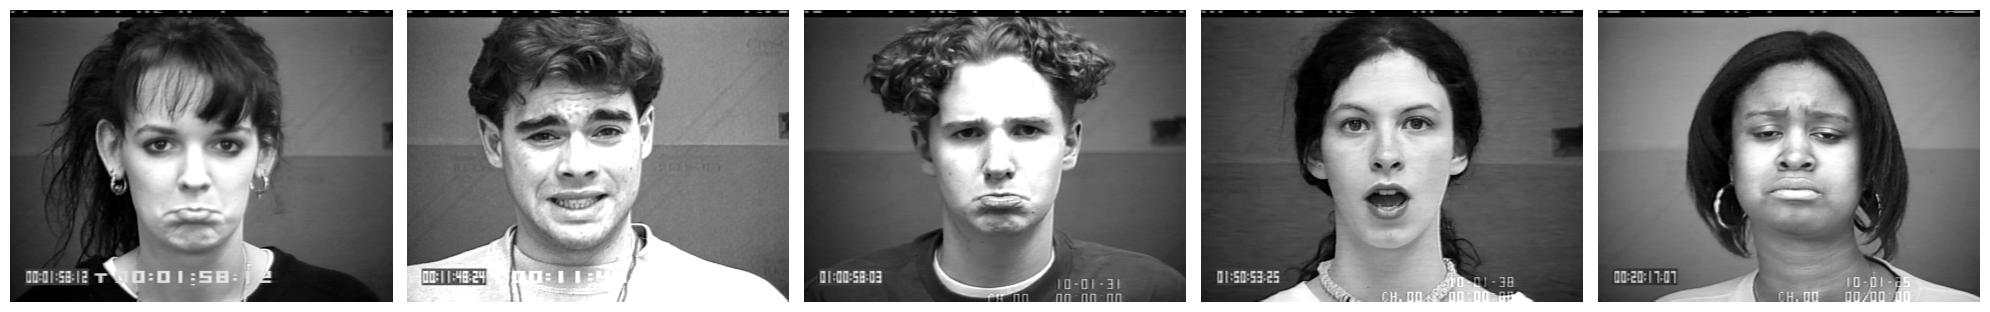

In [11]:
random_images = df['filepath'].sample(5).tolist()


# Creating subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjusting to 5 images

for ax, file in zip(axes, random_images):
    # Correct the file path by replacing the placeholder with the actual image directory
    corrected_file_path = file.replace('./cohn-kanade-images/', IMAGE_DIRECTORY)
    try:
        img = Image.open(corrected_file_path)
        ax.imshow(img, cmap='gray')  # Displaying in grayscale
        ax.axis('off')  # Turning axis off for cleaner look
    except IOError as e:
        print(f"Error opening image: {corrected_file_path} - {e}")

plt.tight_layout()
plt.show()

Observation: The image after using gray scale display a picture of a person with a full head and part of a neck and shoulder. 

In [12]:
# Define an empty list to hold image sizes
image_sizes = []

# Define lists to hold mean and standard deviation of pixel values
mean_pixel_values = []
std_pixel_values = []

# Define a list to hold paths of corrupt images
corrupt_images = []

img_path_list = []
# Loop through the file paths in DataFrame
for file_path in df['filepath']:
    corrected_file_path = file_path.replace('./cohn-kanade-images/', '')
    img_path = os.path.join(IMAGE_DIRECTORY, corrected_file_path)
    img_path_list.append(img_path)
    try:
        # Open the image and convert it to RGB (in case some are grayscale)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Check if the image is read correctly
        if img is not None:
            # Append the image size
            image_sizes.append(img.shape)
            
            # Calculate and store the mean and standard deviation of pixel values
            mean_pixel_values.append(np.mean(img))
            std_pixel_values.append(np.std(img))
        else:
            # If img is None, the image is corrupt
            corrupt_images.append(img_path)
            
    except Exception as e:
        # If an exception is raised, the image is likely corrupt
        corrupt_images.append(img_path)

In [13]:
# Now let's analyze the image sizes
image_sizes = np.array(image_sizes)
unique_sizes = np.unique(image_sizes, axis=0)

# We can print out or plot the unique sizes to decide on a common size
print(f"Unique image sizes: {unique_sizes}")

Unique image sizes: [[480 640   3]
 [480 720   3]
 [490 640   3]]


Observation: 
- The image unique size has 3 channels (RGB) and their unique resolution are ( 480x720 | 480x640 | 490x640) 

In [14]:
# Calculate the overall mean and standard deviation for the pixel values
overall_mean = np.mean(mean_pixel_values)
overall_std = np.std(std_pixel_values)

print(f"Overall mean pixel value: {overall_mean}")
print(f"Overall standard deviation of pixel values: {overall_std}")

# Print out corrupt images, if any
if corrupt_images:
    print("Found corrupt images:")
    for corrupt_img in corrupt_images:
        print(corrupt_img)
else:
    print("No corrupt images found.")

Overall mean pixel value: 99.93890188972647
Overall standard deviation of pixel values: 9.063075756547514
No corrupt images found.


In [15]:
# Background Consistency Check
background_modes = []

for img_path in img_path_list:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscale simplifies the analysis
    border_pixels = np.concatenate([img[0, :], img[-1, :], img[:, 0], img[:, -1]])  # Extract border pixels
    mode = stats.mode(border_pixels)  # Find the mode of the border pixels
    background_modes.append(mode)

/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_99992/3067096416.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(border_pixels)  # Find the mode of the border pixels


Mean mode value: 11.378571428571428
Standard deviation of mode values: 47.69470887951871


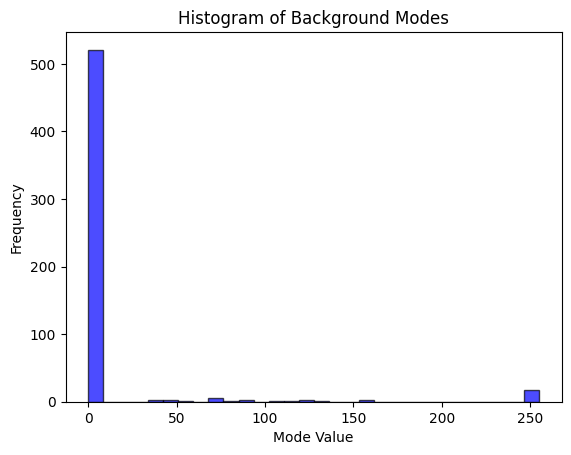

In [16]:
# Extract the mode values and counts
mode_values = [mode.mode[0] for mode in background_modes]
mode_counts = [mode.count[0] for mode in background_modes]

# Calculate basic statistics
mean_mode = np.mean(mode_values)
std_dev_mode = np.std(mode_values)

print(f"Mean mode value: {mean_mode}")
print(f"Standard deviation of mode values: {std_dev_mode}")

# Visualize the distribution of mode values
plt.hist(mode_values, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Background Modes')
plt.xlabel('Mode Value')
plt.ylabel('Frequency')
plt.show()

Observation: The image has imbalance background after grayscale. According to the bar plot the zero pixels are higher than the others pixels from (pixels raise from 0 to 255)

2.2 Action Units Analysis

In [17]:
AU_cols = [col for col in df.columns if 'AU' in col]
print(list(df.columns))
print(AU_cols)
# Counting the number of unique AU_cols
num_unique_AU_cols = len(AU_cols)
# Displaying the count
num_unique_AU_cols
print("Unique Action Unit Codes:", num_unique_AU_cols)

['subject', 'sequence', 'image_index', 'filepath', 'file_prefix', 'AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4', 'AU7', 'AU23', 'AU24', 'AU6', 'AU12', 'AU15', 'AU14', 'AU11', 'AU26', 'high_level_emotion', 'high_level_emotion_num']
['AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4', 'AU7', 'AU23', 'AU24', 'AU6', 'AU12', 'AU15', 'AU14', 'AU11', 'AU26']
Unique Action Unit Codes: 15


Observation: The df have 22 columsn and 15 unique action units columsn 

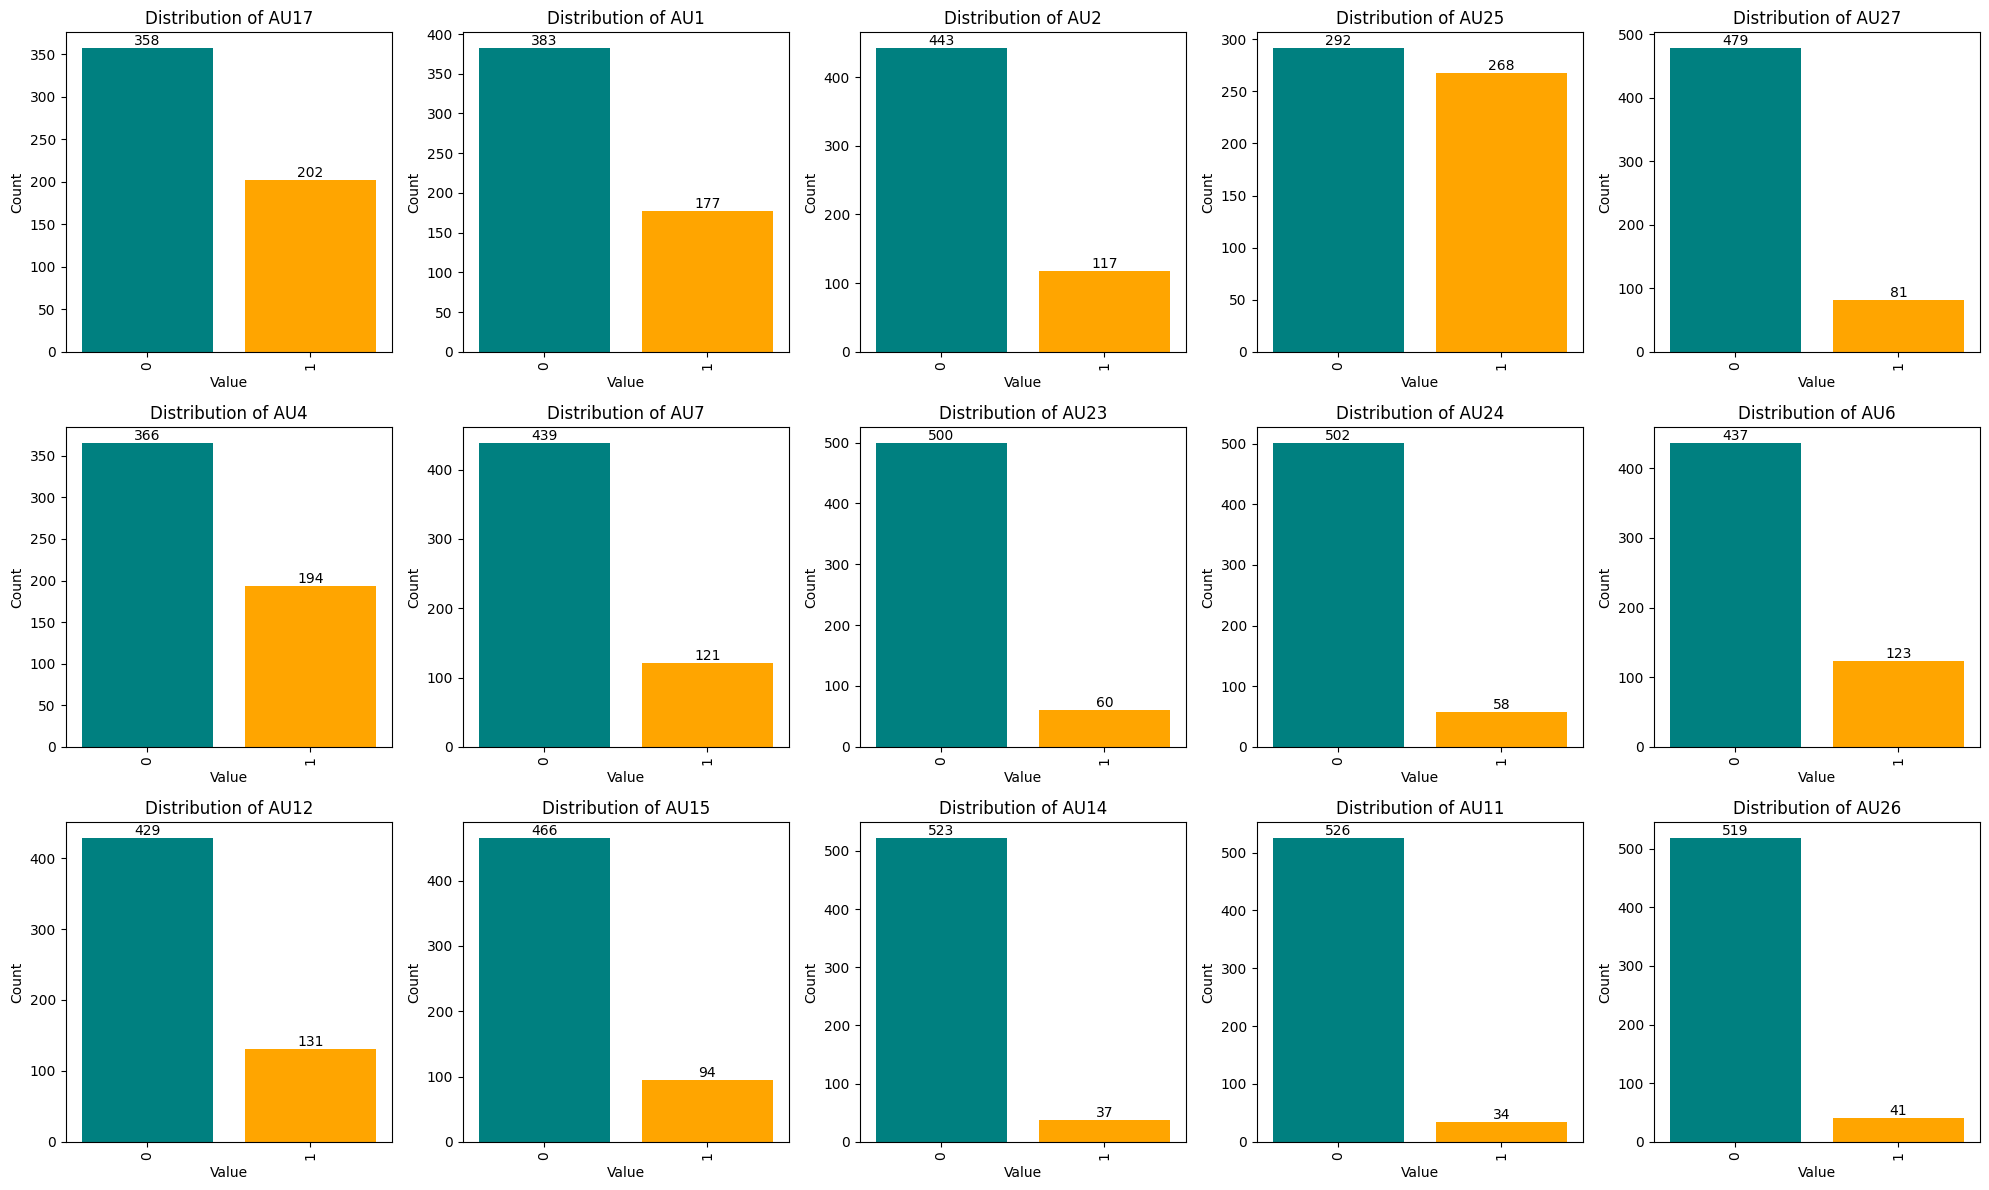

In [18]:
# Plotting the bar charts with value counts displayed on top of each bar
plt.figure(figsize=(20, 12))

rows = 3
cols = 5

for i, col in enumerate(AU_cols):
    plt.subplot(rows, cols, i + 1)
    counts = df[col].value_counts()
    counts.plot(kind='bar', color='green')

    # Displaying the count numbers on top of each bar
    for index, value in enumerate(counts):
        bar_color = 'teal' if index == 0 else 'orange'  # Set color based on class
        plt.bar(index, value, color=bar_color)
        plt.text(index, value, str(value), ha='center', va='bottom')

    plt.title(f'Distribution of {col}')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['0', '1'])

plt.tight_layout()
plt.show()


Observation: For most of the Action Unit code the 1 values are clearly less than the 0 values except the AU25 (value 1: 268 | value 0: 292)

## [3] SETUP AND EXTRACT ESSENTIAL DATA 

Preprocess and Saved to new folder

In [19]:
# import os
# import dlib
# import numpy as np  # Make sure to import numpy
# from PIL import Image

# # Correct the directory path
# IMAGE_DIRECTORY = "./data-1/cohn-kanade-images/"
# NEW_IMAGE_DIRECTORY = "./data-1/cohn-kanade-images/cropped/"

# # Load the face detector
# detector = dlib.get_frontal_face_detector()

# # Ensure the new directory exists
# if not os.path.exists(NEW_IMAGE_DIRECTORY):
#     os.makedirs(NEW_IMAGE_DIRECTORY)

# # Load the landmark predictor - ensure you have the correct path to the predictor file
# predictor_path = 'shape_predictor_68_face_landmarks.dat'  # Replace with your path
# landmark_predictor = dlib.shape_predictor(predictor_path)

# def crop_faces(df):
#     df['cropped_image_path'] = None
#     for index, row in df.iterrows():
#         corrected_file_path = row['filepath'].replace('./cohn-kanade-images/', '')
#         img_path = os.path.join(IMAGE_DIRECTORY, corrected_file_path)
#         try:
#             img = Image.open(img_path)
#         except FileNotFoundError:
#             print(f"File not found: {img_path}")
#             continue

#         gray_img = np.array(img.convert('L'))

#         detected_faces = detector(gray_img, 1)
#         for i, face_rect in enumerate(detected_faces):
#             # Get facial landmarks
#             landmarks = landmark_predictor(gray_img, face_rect)
#             eyebrow_heights = [landmarks.part(i).y for i in range(17, 27)]
#             top_point = min(eyebrow_heights) - (face_rect.bottom() - face_rect.top()) // 4  
#             # Use the landmarks for the sides of the face
#             left_point = landmarks.part(0).x  # Point 1 in the 68 landmarks
#             right_point = landmarks.part(16).x  # Point 17 in the 68 landmarks
#             # Determine the bottom of the face (chin)
#             bottom_point = landmarks.part(8).y + (face_rect.bottom() - face_rect.top()) // 6
#             # Adjust the crop to include the chin
#             crop = img.crop((left_point, top_point, right_point, bottom_point))
#             cropped_img_path = os.path.join(NEW_IMAGE_DIRECTORY, f"{row['file_prefix']}_cropped.png")
#             crop.save(cropped_img_path)
#             cropped_img_path = cropped_img_path.replace('data-1/', '')
#             df.at[index, 'cropped_image_path'] = cropped_img_path
#             break
#     return df
# # Example usage:
# # Make sure your DataFrame 'df' has 'filepath' and 'file_prefix' columns with correct paths.
# df_updated = crop_faces(df)
# df_updated.to_csv('updated_data.csv', index=False)


3.1 Build Dataloader

In [20]:
new_df = pd.read_csv('updated_data.csv')

from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CustomDataLoader(Sequence):
    def __init__(self, file_paths, labels, batch_size, image_size, shuffle, augment):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

        # Data augmentation configuration
        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        else:
            self.datagen = ImageDataGenerator()

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_file_paths = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = {k: np.array(v[index * self.batch_size:(index + 1) * self.batch_size]) for k, v in self.labels.items()}

        X = np.array([self._load_image(path) for path in batch_file_paths])
        y = batch_labels
        # print(f"Batch X shape: {X.shape}, Batch y shape: {y['emotion_output'].shape}")
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.file_paths, *self.labels.values()))
            np.random.shuffle(temp)
            self.file_paths, *label_values = zip(*temp)
            self.labels = {k: list(v) for k, v in zip(self.labels.keys(), label_values)}

    def _load_image(self, file_path):
        # Load and preprocess the image
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.image_size)
        img = img / 255.0  # Normalize to [0, 1]
        img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale
        return img

3.2 Apply Dataloader

In [21]:
##### THIS BLOCK OF CODE ADDED STRATIFICATION INTO THE SPLIT
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

RANDOM_STATE = 42
TEST_SIZE = 0.2
au_codes = [17, 1, 2, 25, 27, 4, 7, 23, 24, 6, 12, 15, 14, 11, 26]
au_codes_high = [1, 2, 4, 7, 6]
au_codes_low = [17,25,27,23,24,12,15,14,11,26]

# Convert 'high_level_emotion' to numerical labels for stratification
label_encoder = LabelEncoder()
encoded_emotions = label_encoder.fit_transform(new_df['high_level_emotion'])

# Modify file paths
n_image_filepaths = [path[:2] + "data-1/" + path[2:] for path in new_df['cropped_image_path']]
# n_image_filepaths = [path[:2] + "data-1/" for path in new_df['cropped_image_path']]
print(n_image_filepaths)

# Split the data into training and validation sets with stratification
X_train_paths, X_temp_paths, y_train_emotion, y_temp_emotion = train_test_split(
    n_image_filepaths, encoded_emotions, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=encoded_emotions
)
X_val_paths, X_test_paths, y_val_emotion, y_test_emotion = train_test_split(
    X_temp_paths, y_temp_emotion, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp_emotion
)

train = [path.replace('data-1/', '') for path in X_train_paths]
val = [path.replace('data-1/', '') for path in X_val_paths]
test = [path.replace('data-1/', '') for path in X_test_paths]

# Prepare and split AU labels according to train, val, and test splits
train_labels, val_labels, test_labels = {}, {}, {}
for au_code in au_codes:
    train_labels[f'AU{au_code}_output'] = new_df.loc[new_df['cropped_image_path'].isin(train), f'AU{au_code}'].values
    val_labels[f'AU{au_code}_output'] = new_df.loc[new_df['cropped_image_path'].isin(val), f'AU{au_code}'].values
    test_labels[f'AU{au_code}_output'] = new_df.loc[new_df['cropped_image_path'].isin(test), f'AU{au_code}'].values

# Convert emotion_output labels to categorical
y_train_emotion_cat = to_categorical(y_train_emotion, num_classes=3)
y_val_emotion_cat = to_categorical(y_val_emotion, num_classes=3)
y_test_emotion_cat = to_categorical(y_test_emotion, num_classes=3)

# Added Emotion_Output
train_labels['emotion_output'] = y_train_emotion_cat
val_labels['emotion_output'] = y_val_emotion_cat
test_labels['emotion_output'] = y_test_emotion_cat

# Create loaders for train, val, test
train_loader = CustomDataLoader(X_train_paths, train_labels, batch_size=32, image_size=(48, 48), shuffle=True, augment=True)
val_loader = CustomDataLoader(X_val_paths, val_labels, batch_size=32, image_size=(48, 48), shuffle=False, augment=False)
test_loader = CustomDataLoader(X_test_paths, test_labels, batch_size=32, image_size=(48, 48), shuffle=False, augment=False)


['./data-1/cohn-kanade-images/cropped/S005_001_00000011_cropped.png', './data-1/cohn-kanade-images/cropped/S010_001_00000014_cropped.png', './data-1/cohn-kanade-images/cropped/S010_002_00000014_cropped.png', './data-1/cohn-kanade-images/cropped/S010_003_00000018_cropped.png', './data-1/cohn-kanade-images/cropped/S010_004_00000019_cropped.png', './data-1/cohn-kanade-images/cropped/S010_005_00000016_cropped.png', './data-1/cohn-kanade-images/cropped/S010_006_00000015_cropped.png', './data-1/cohn-kanade-images/cropped/S011_001_00000016_cropped.png', './data-1/cohn-kanade-images/cropped/S011_002_00000022_cropped.png', './data-1/cohn-kanade-images/cropped/S011_003_00000014_cropped.png', './data-1/cohn-kanade-images/cropped/S011_004_00000021_cropped.png', './data-1/cohn-kanade-images/cropped/S011_005_00000020_cropped.png', './data-1/cohn-kanade-images/cropped/S011_006_00000013_cropped.png', './data-1/cohn-kanade-images/cropped/S014_001_00000029_cropped.png', './data-1/cohn-kanade-images/crop

In [22]:
#  Calculate class weight for the facs codes
from sklearn.utils.class_weight import compute_class_weight

train_class_weights = {}
# Calculate class weights for each AU output
for au_code in au_codes:
    au_labels = train_labels[f'AU{au_code}_output']
    au_class_weights = compute_class_weight('balanced', classes=np.unique(au_labels), y=au_labels)
    train_class_weights[f'AU{au_code}_output'] = dict(enumerate(au_class_weights))

3.3 Visualise Processed Data

In [23]:
import random

def display_random_images(data_loader, title, num_images=5):
    # Retrieve a batch of images
    batch_images, _ = next(iter(data_loader))
    
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        idx = random.randint(0, batch_images.shape[0] - 1)
        image = batch_images[idx]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"{title} {idx}")
        plt.axis('off')
    plt.show()

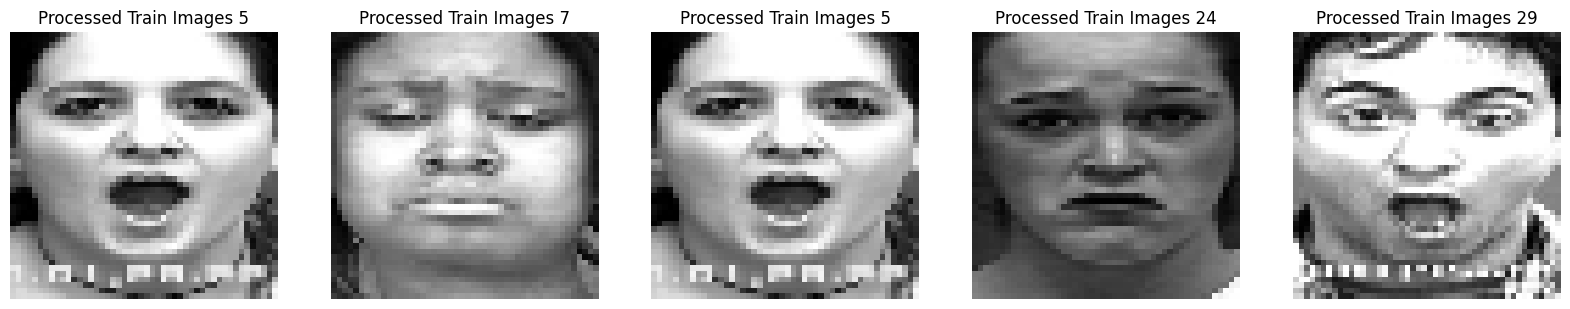

In [24]:
# Train
display_random_images(train_loader, "Processed Train Images")

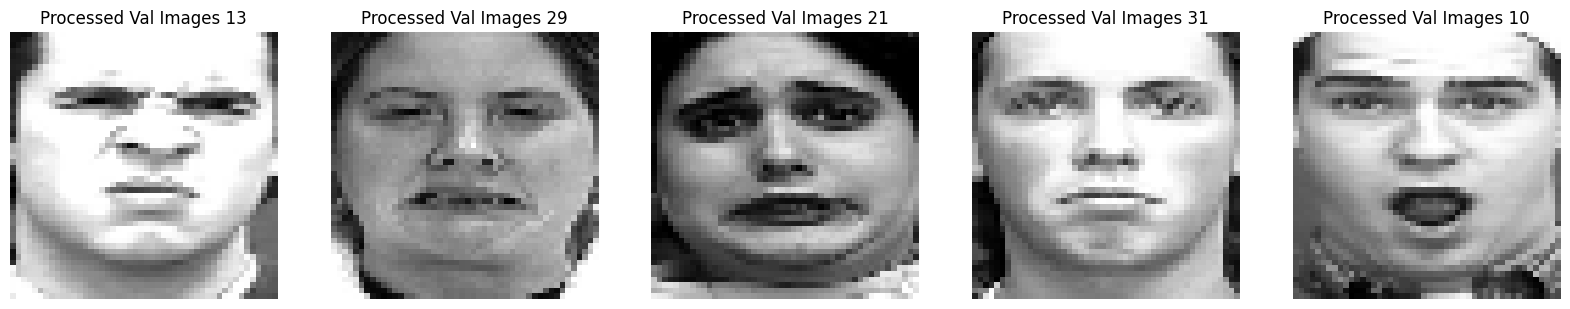

In [25]:
# Val
display_random_images(val_loader, "Processed Val Images")

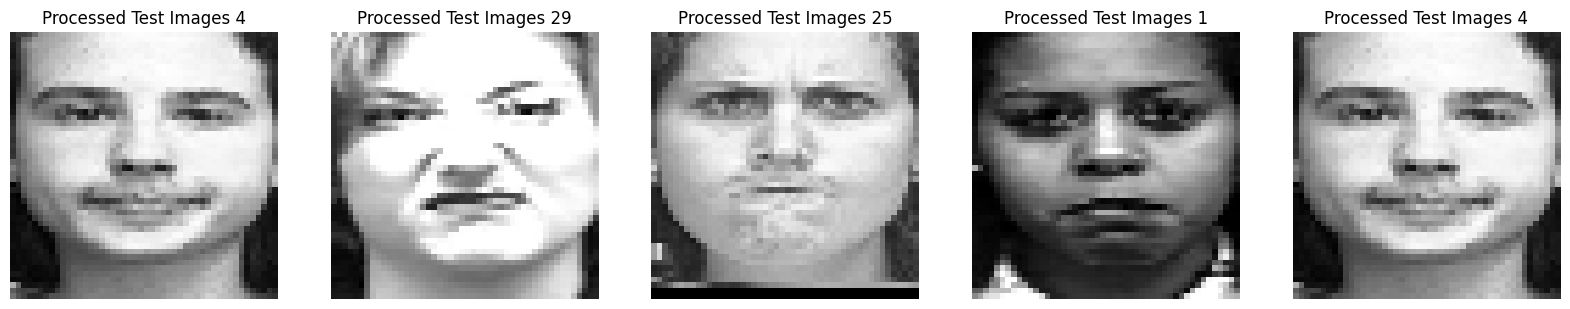

In [26]:
# Test
display_random_images(test_loader, "Processed Test Images")

## [4] MODEL TRAINING

4.1 Set Up Loss Function

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.metrics import Precision, Recall

In [28]:
from tensorflow.keras import backend as K
import tensorflow as tf

def weighted_binary_crossentropy(weights):
    def w_binary_crossentropy(y_true, y_pred):
        # Convert class weights to float32
        weight_for_0 = tf.cast(weights[0], dtype=tf.float32)
        weight_for_1 = tf.cast(weights[1], dtype=tf.float32)
        # Convert y_true to float32 if it's not already
        y_true = tf.cast(y_true, dtype=tf.float32)
        # Calculate the binary crossentropy
        bce = K.binary_crossentropy(y_true, y_pred)
        # Apply the weights
        weight_vector = y_true * weight_for_1 + (1.0 - y_true) * weight_for_0
        weighted_bce = weight_vector * bce

        return K.mean(weighted_bce)

    return w_binary_crossentropy

# Creating custom loss functions for each output
losses = {output: weighted_binary_crossentropy(weights) for output, weights in train_class_weights.items()}
losses['emotion_output'] = "categorical_crossentropy"


In [29]:
# Define the input layer
input_layer = Input(shape=(48, 48, 1))
x = input_layer
# Define the shared CNN layers
dropout_rate = 0.5

# Share 1st CNN
x = Conv2D(32, (3, 3), 1, padding='same' ,activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Dropout(dropout_rate)(x)

# 2nd CNN for high au_code and emtion detection
x = Conv2D(32, (3, 3), 1, padding='same' , activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Dropout(dropout_rate)(x)

# 3rd CNN for high au_code and emtion detection
shared = Conv2D(32, (3, 3), 1, padding='same' , activation='relu', kernel_regularizer=l2(0.001))(x)
shared = BatchNormalization()(shared)
shared = MaxPooling2D()(shared)
shared = Dropout(dropout_rate)(shared)

# ================================================== START low AU_CODE layers
y = Conv2D(64, (3, 3), 1, padding='same' ,activation='relu', kernel_regularizer=l2(0.001))(shared)
y = BatchNormalization()(y)
y = MaxPooling2D()(y)
y = Dropout(dropout_rate)(y)

y = Flatten()(y)
y = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(y)
y = BatchNormalization()(y)
y = Dropout(dropout_rate)(y)

# Individual branches for AU25 and AU4 FACS code
au_outputs2 = []
for au_code in au_codes: 
    output = Dense(1, activation='sigmoid', name=f'AU{au_code}_output')(y)
    au_outputs2.append(output)

# ================================================== END low AU_CODE layers

# Flattern
x = Flatten()(shared)

# Define the emotion output branch

# Emotion Branch
emotion_branch = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
emotion_branch = Dropout(0.3)(emotion_branch)
emotion_output = Dense(3, activation='softmax', name='emotion_output')(emotion_branch)

# Create the model with inputs from the input layer and outputs from both branches
model = Model(inputs=input_layer, outputs=[emotion_output] + au_outputs2)

# Compile the model with appropriate loss functions for each output and the optimizer
learning_rate = 1e-3
learning_rate = 0.01
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt,
              loss = losses,
              metrics=['accuracy'])

# Print the model summary
model.summary()


2023-12-06 16:26:53.666291: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-12-06 16:26:53.666312: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-06 16:26:53.666315: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-06 16:26:53.666348: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-06 16:26:53.666364: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 32)           320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 48, 48, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)           0         ['batch_normalization[0][0

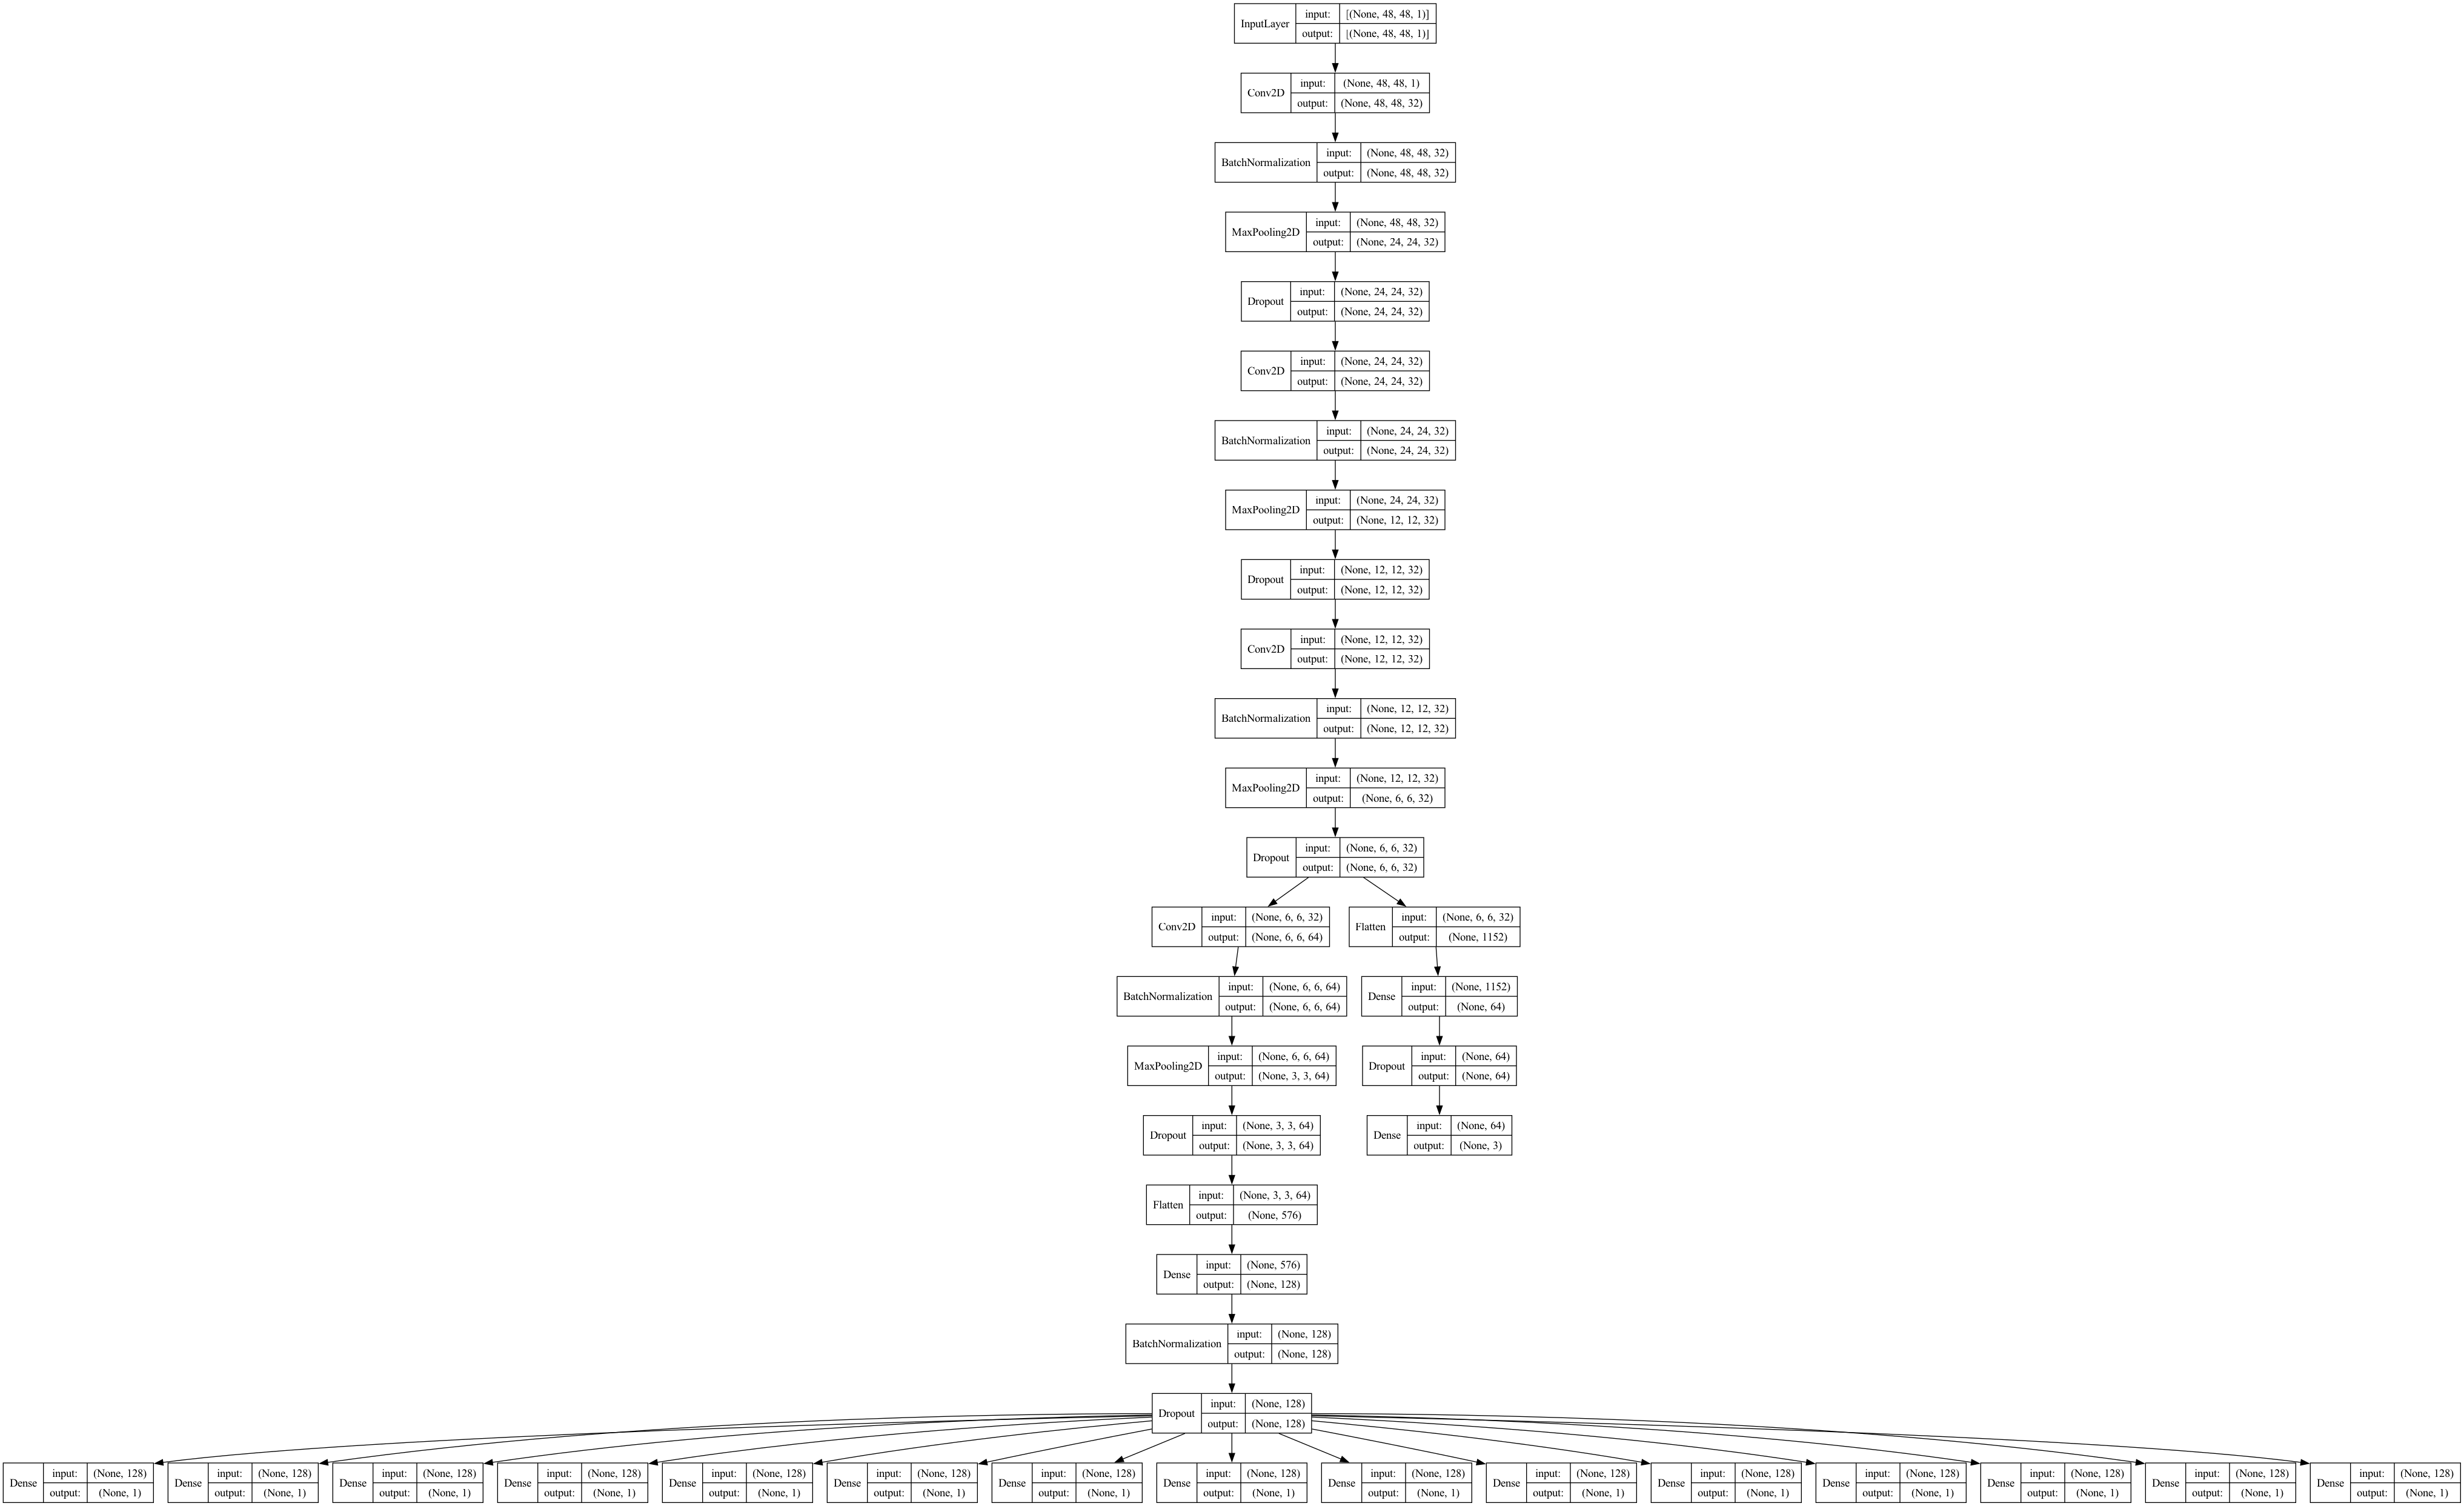

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_layer_names=False, show_shapes=True, to_file='model.png')

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Define the EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-5,
    verbose=1,
)

# Define the ModelCheckpoint callback
checkpoint_path = "best_model2.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,    # Only save a model if 'val_loss' has improved
    monitor='val_loss',     # Monitor 'val_loss' during training
    mode='min',             # The model is saved when 'val_loss' is minimized
    verbose=1)

# Combine all callbacks in a list
callbacks = [
    early_stopping,
    lr_scheduler,
    model_checkpoint_callback
]

In [32]:
# Change in training configuration
epochs = 1000

history = model.fit(train_loader, 
                    validation_data=val_loader, 
                    epochs=epochs,
                    callbacks = callbacks)

Epoch 1/1000


2023-12-06 16:26:57.022154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 30.3415 - emotion_output_loss: 13.3644 - AU17_output_loss: 0.9632 - AU1_output_loss: 1.0428 - AU2_output_loss: 0.9953 - AU25_output_loss: 1.0320 - AU27_output_loss: 1.0958 - AU4_output_loss: 0.9690 - AU7_output_loss: 1.1136 - AU23_output_loss: 1.0941 - AU24_output_loss: 1.1490 - AU6_output_loss: 1.0751 - AU12_output_loss: 1.0841 - AU15_output_loss: 1.0505 - AU14_output_loss: 1.3217 - AU11_output_loss: 1.0886 - AU26_output_loss: 1.3056 - emotion_output_accuracy: 0.3996 - AU17_output_accuracy: 0.5290 - AU1_output_accuracy: 0.5045 - AU2_output_accuracy: 0.4844 - AU25_output_accuracy: 0.4688 - AU27_output_accuracy: 0.4665 - AU4_output_accuracy: 0.5558 - AU7_output_accuracy: 0.4754 - AU23_output_accuracy: 0.5246 - AU24_output_accuracy: 0.4866 - AU6_output_accuracy: 0.5089 - AU12_output_accuracy: 0.4688 - AU15_output_accuracy: 0.5000 - AU14_output_accuracy: 0.5312 - AU11_output_accuracy: 0.5156 - AU26_output_accuracy: 0.4866

2023-12-06 16:27:03.108622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 36.71112, saving model to best_model2.h5
14/14 [==============================] - 11s 446ms/step - loss: 30.3415 - emotion_output_loss: 13.3644 - AU17_output_loss: 0.9632 - AU1_output_loss: 1.0428 - AU2_output_loss: 0.9953 - AU25_output_loss: 1.0320 - AU27_output_loss: 1.0958 - AU4_output_loss: 0.9690 - AU7_output_loss: 1.1136 - AU23_output_loss: 1.0941 - AU24_output_loss: 1.1490 - AU6_output_loss: 1.0751 - AU12_output_loss: 1.0841 - AU15_output_loss: 1.0505 - AU14_output_loss: 1.3217 - AU11_output_loss: 1.0886 - AU26_output_loss: 1.3056 - emotion_output_accuracy: 0.3996 - AU17_output_accuracy: 0.5290 - AU1_output_accuracy: 0.5045 - AU2_output_accuracy: 0.4844 - AU25_output_accuracy: 0.4688 - AU27_output_accuracy: 0.4665 - AU4_output_accuracy: 0.5558 - AU7_output_accuracy: 0.4754 - AU23_output_accuracy: 0.5246 - AU24_output_accuracy: 0.4866 - AU6_output_accuracy: 0.5089 - AU12_output_accuracy: 0.4688 - AU15_output_accuracy: 0.5000 - AU14_output_a

/Users/vuvoquoc/miniforge3/envs/tf/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - ETA: 0s - loss: 20.1423 - emotion_output_loss: 6.0111 - AU17_output_loss: 0.7849 - AU1_output_loss: 0.8416 - AU2_output_loss: 0.8729 - AU25_output_loss: 0.8620 - AU27_output_loss: 0.8084 - AU4_output_loss: 0.8796 - AU7_output_loss: 0.7764 - AU23_output_loss: 0.9078 - AU24_output_loss: 0.8315 - AU6_output_loss: 1.0027 - AU12_output_loss: 0.8248 - AU15_output_loss: 0.8530 - AU14_output_loss: 1.0678 - AU11_output_loss: 1.0121 - AU26_output_loss: 0.9216 - emotion_output_accuracy: 0.4978 - AU17_output_accuracy: 0.5357 - AU1_output_accuracy: 0.5469 - AU2_output_accuracy: 0.4955 - AU25_output_accuracy: 0.4933 - AU27_output_accuracy: 0.5625 - AU4_output_accuracy: 0.5000 - AU7_output_accuracy: 0.5179 - AU23_output_accuracy: 0.4888 - AU24_output_accuracy: 0.5558 - AU6_output_accuracy: 0.4799 - AU12_output_accuracy: 0.5558 - AU15_output_accuracy: 0.5045 - AU14_output_accuracy: 0.4978 - AU11_output_accuracy: 0.4732 - AU26_output_accuracy: 0.4732
Epoch 2: va

4.2 Plot losses

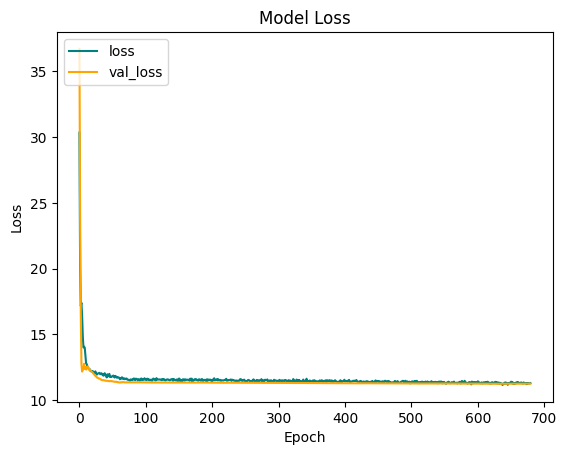

In [33]:
fig = plt.Figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('losses', fontsize = 20)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc = 'upper left')
plt.show()

4.3 Plot Emotion Output Accuracies

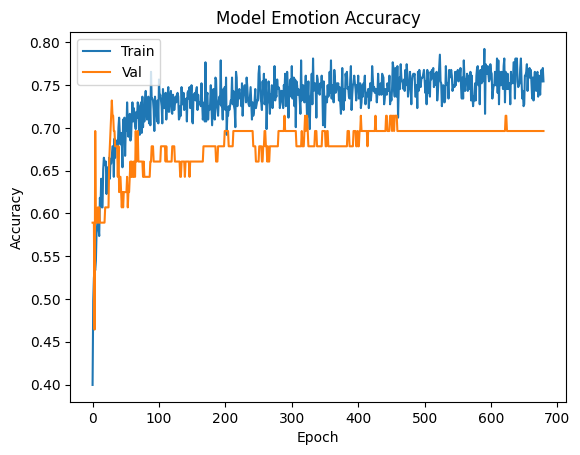

In [34]:
plt.plot(history.history['emotion_output_accuracy'])
plt.plot(history.history['val_emotion_output_accuracy'])
plt.title('Model Emotion Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## [5] EVALUATE BEST MODEL PERFORMANCE

In [35]:
from tensorflow.keras.models import load_model

In [36]:
def generate_predictions(model, data_loader):
    emotion_predictions = []
    emotion_true = []
    facs_predictions = {au_code: [] for au_code in au_codes}
    facs_true = {au_code: [] for au_code in au_codes}

    for X, y in data_loader:
        preds = model.predict(X)
        emotion_predictions.extend(preds[0])
        emotion_true.extend(y['emotion_output'])

        # Assuming each model predicts only one FACS code
        facs_pred = preds[1].flatten()  # Flattening since it's a single value
        for au_code in au_codes:
            facs_predictions[au_code].extend(facs_pred)
            facs_true[au_code].extend(y[f'{au_code}_output'])

    return (np.array(emotion_predictions), np.array(emotion_true)), \
           {au_code: np.array(facs_predictions[au_code]) for au_code in au_codes}, \
           {au_code: np.array(facs_true[au_code]) for au_code in au_codes}

In [37]:
# Load the best model
# model = load_model('best_model.h5')
model = load_model('best_model2.h5', custom_objects={'w_binary_crossentropy': weighted_binary_crossentropy(train_class_weights)})

In [38]:
predictions = model.predict(test_loader)

2023-12-06 16:53:21.615286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 137ms/step


In [39]:
facs_predictions, emotion_predictions = predictions[1:16],predictions[0]

In [40]:
# Processing FACS predictions: Convert probabilities to binary values to string
au_codes = ["AU17", "AU1", "AU2", "AU25", "AU27", "AU4", "AU7", "AU23", "AU24", "AU6", "AU12", "AU15", "AU14", "AU11", "AU26"]
facs_pred_binary = []
for i in facs_predictions:
    facs_pred_binary.append((i > 0.5).astype(int))

grouped_facs = []
for i in range(len(emotion_predictions)):
    group = [facs_pred_binary[j][i][0] for j in range(15)]
    grouped_facs.append(group)

pred_facs = []
for item in grouped_facs:
    selected_codes = [code for code, value in zip(au_codes, item) if value == 1]
    pred_facs.append(selected_codes)

In [41]:
# Processing Emotion predictions: Convert probabilities to class labels
emotion_pred_labels = np.argmax(emotion_predictions, axis=1)
names = ['negative','positive','surprise']
def getLabel(id):
    return ['negative','positive','surprise'][id]

pred_emotions = []
for emotion in emotion_pred_labels:
    pred_emotions.append(getLabel(emotion))

1/1 [==============================] - 0s 247ms/step


2023-12-06 16:53:22.212052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 259ms/step


2023-12-06 16:53:22.521623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


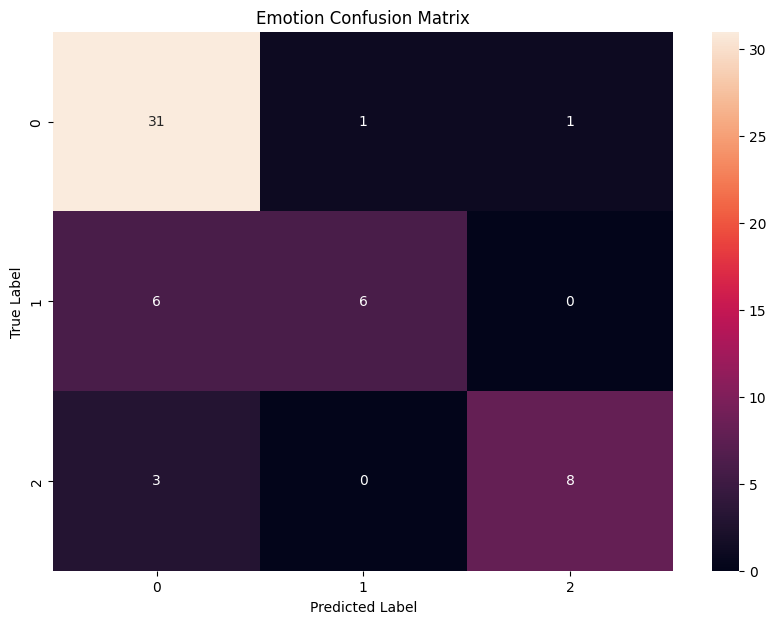

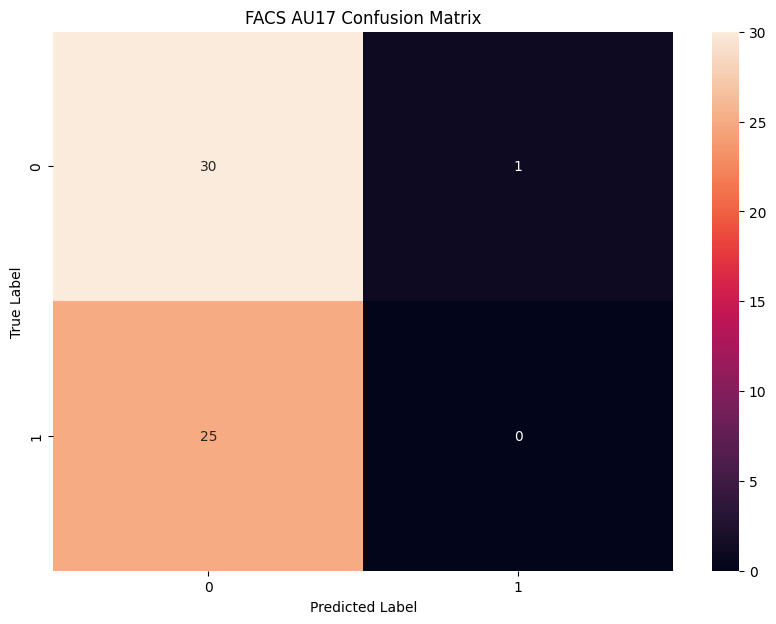

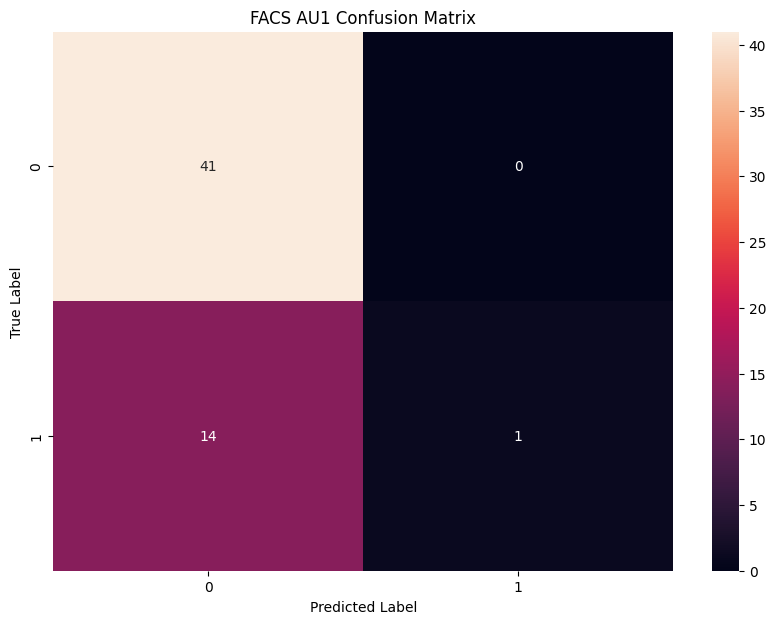

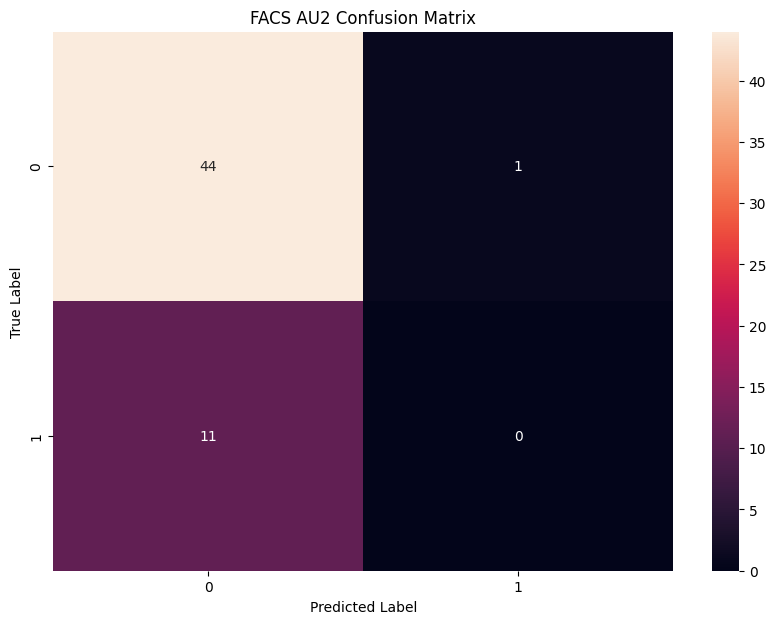

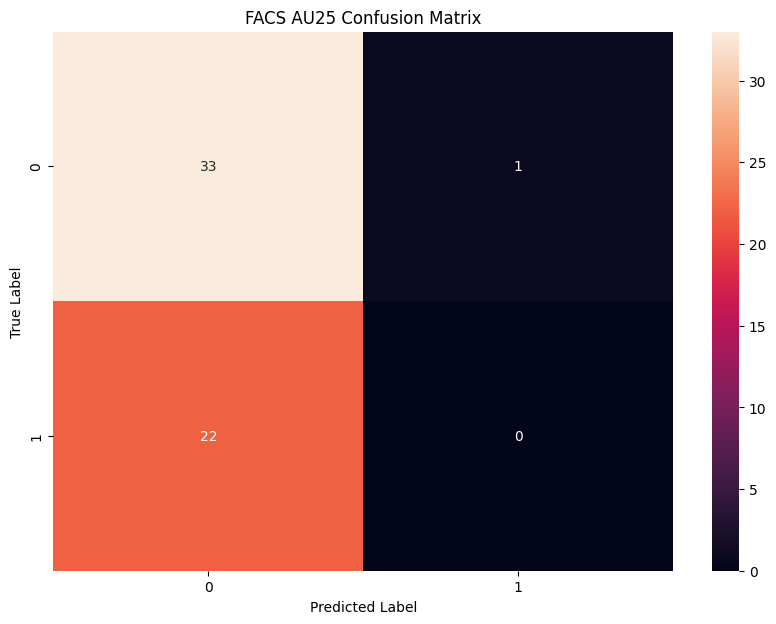

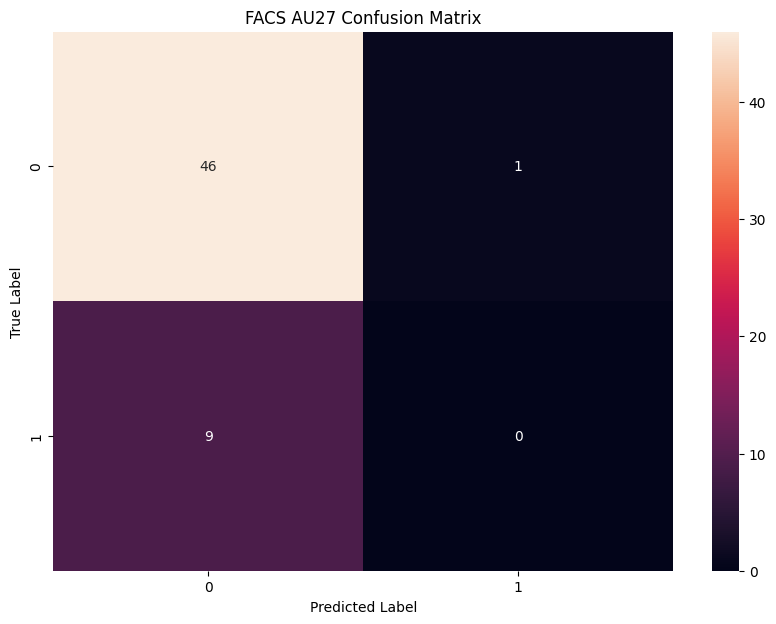

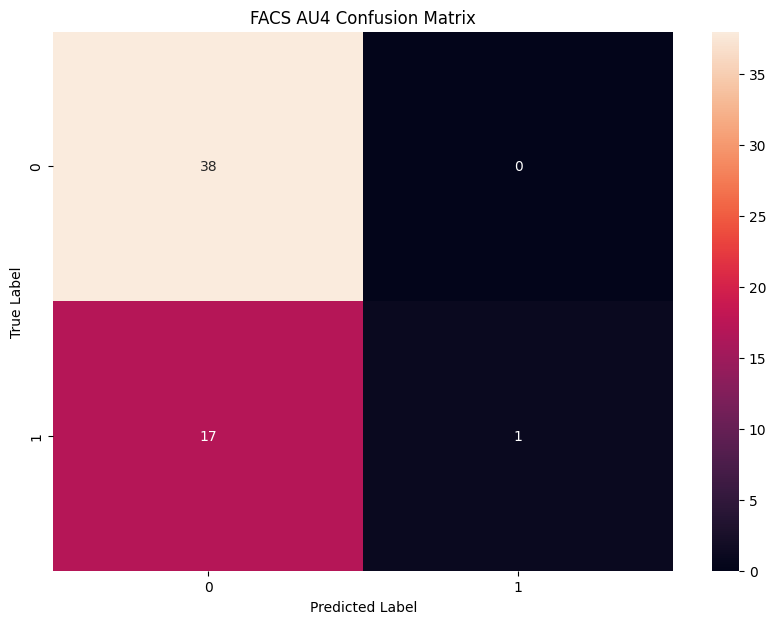

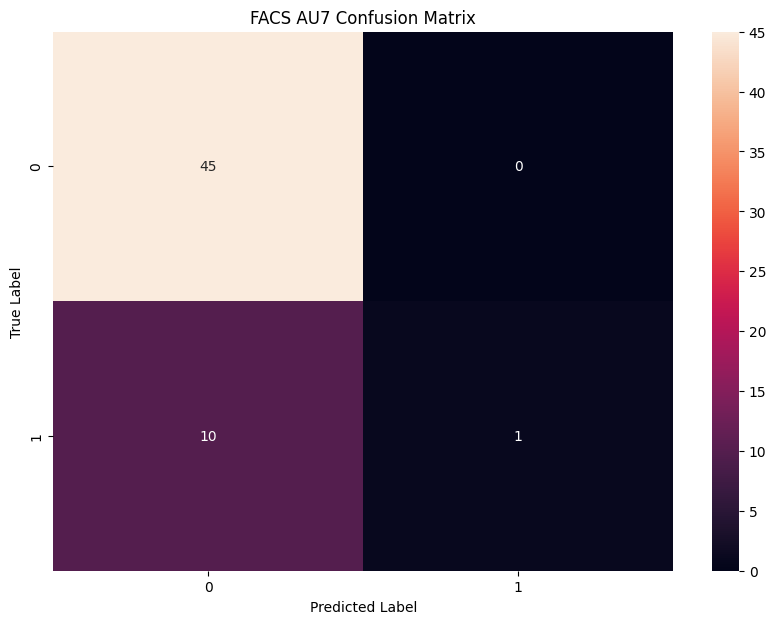

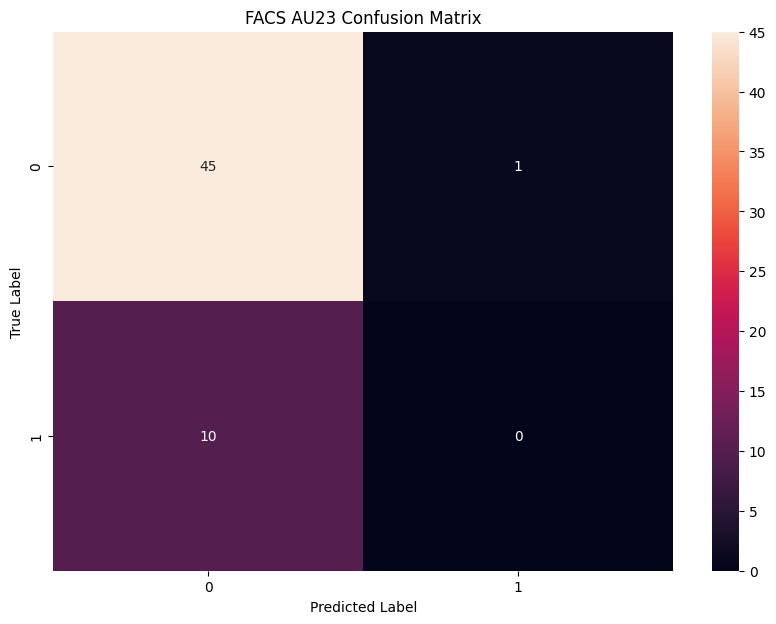

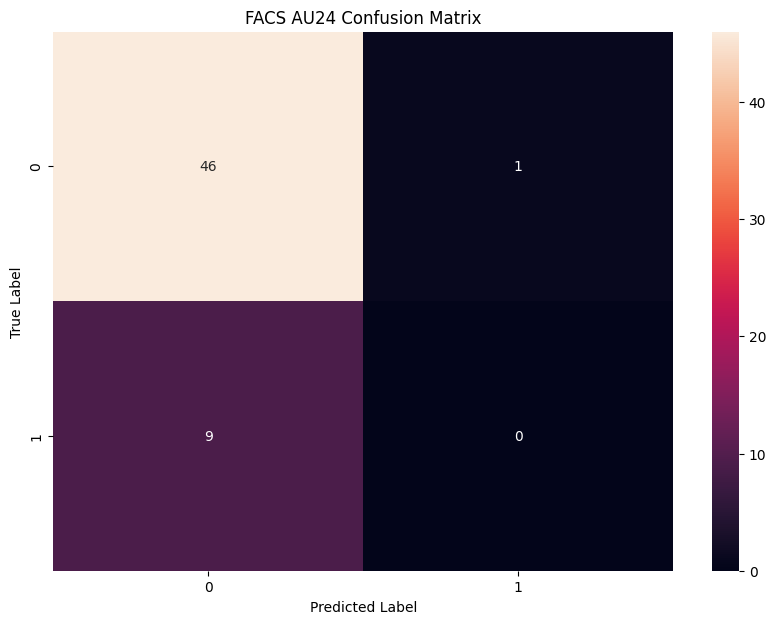

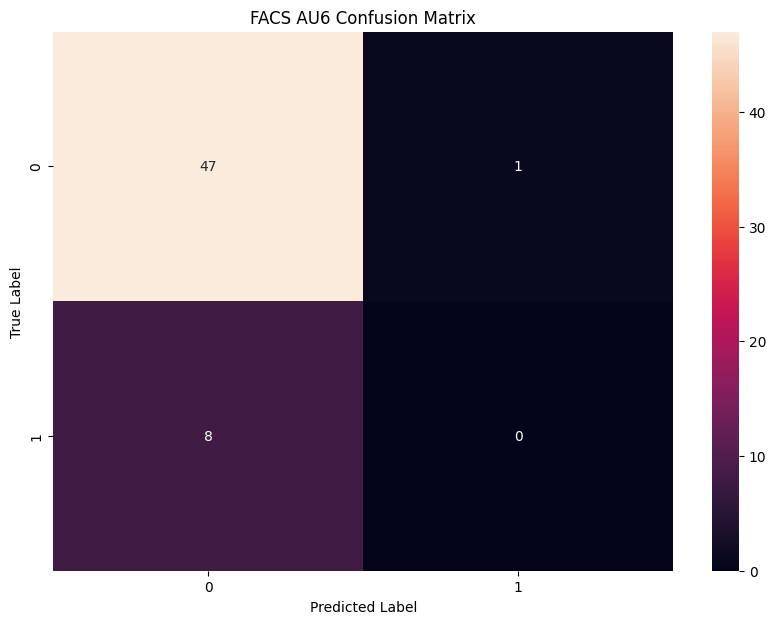

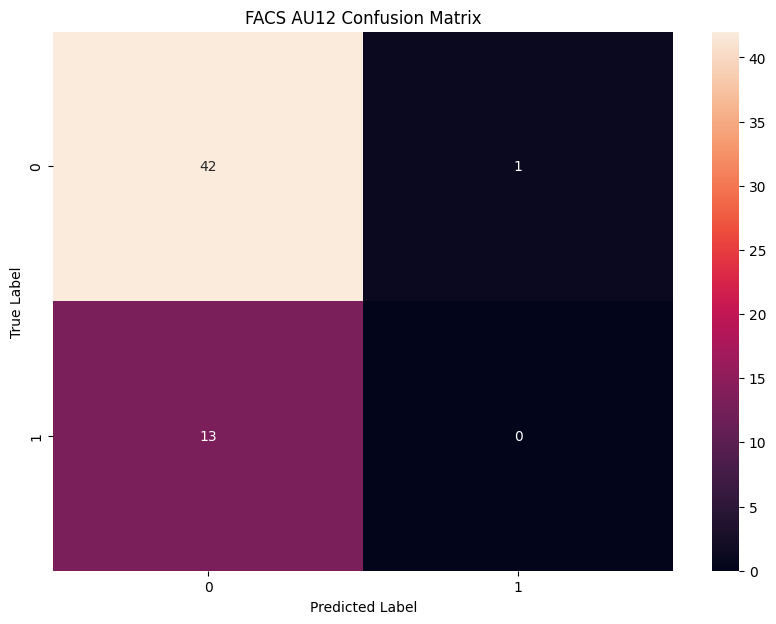

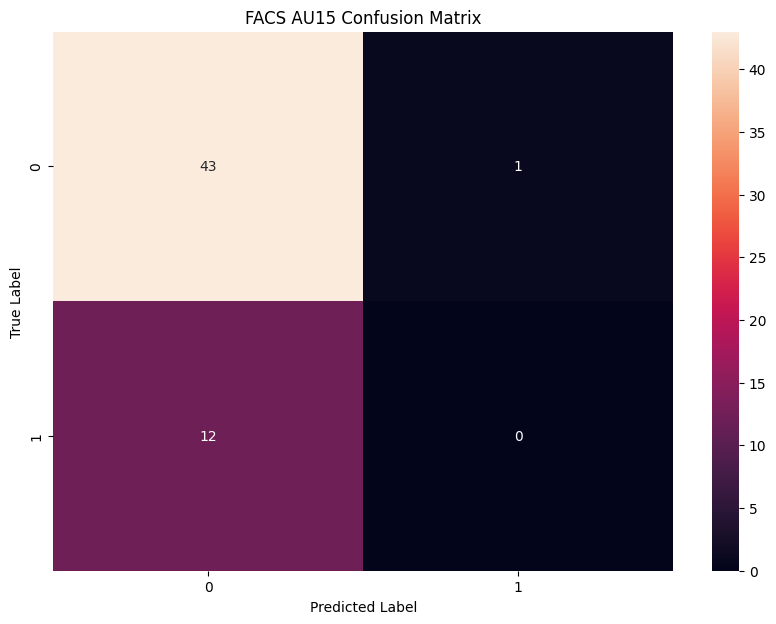

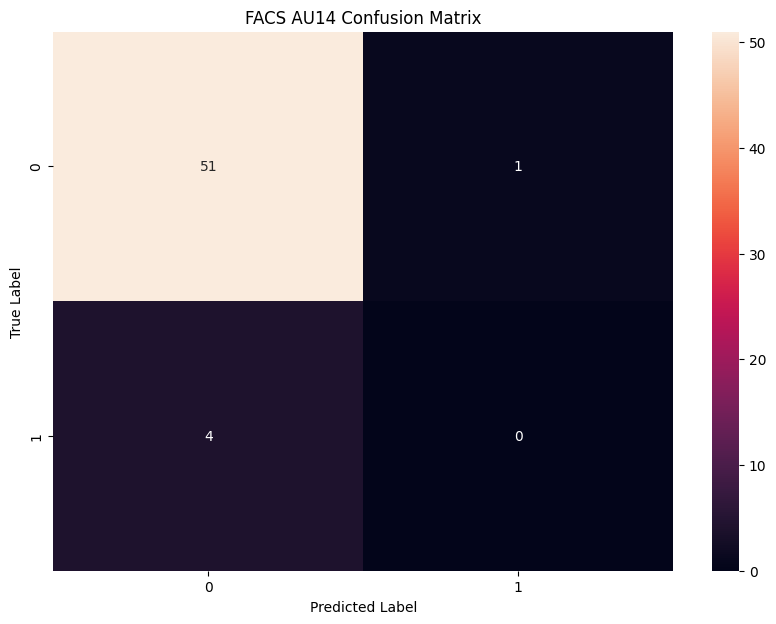

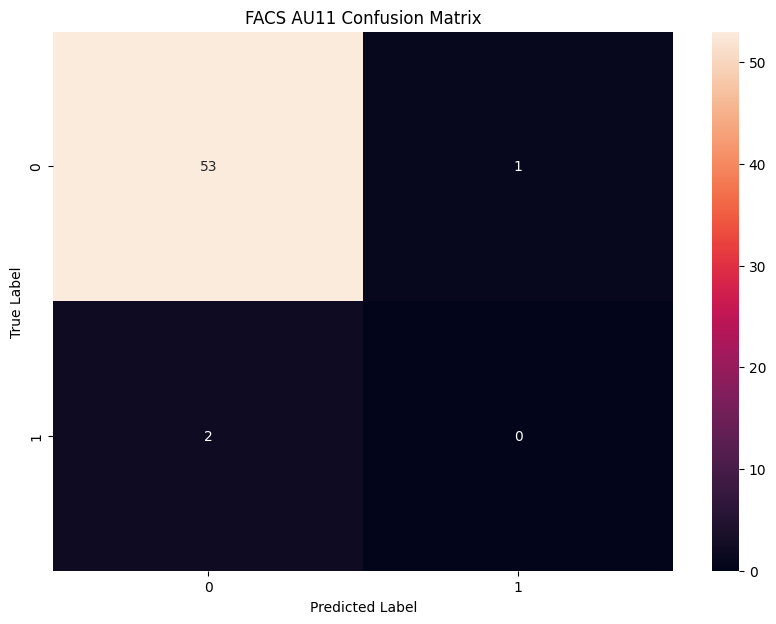

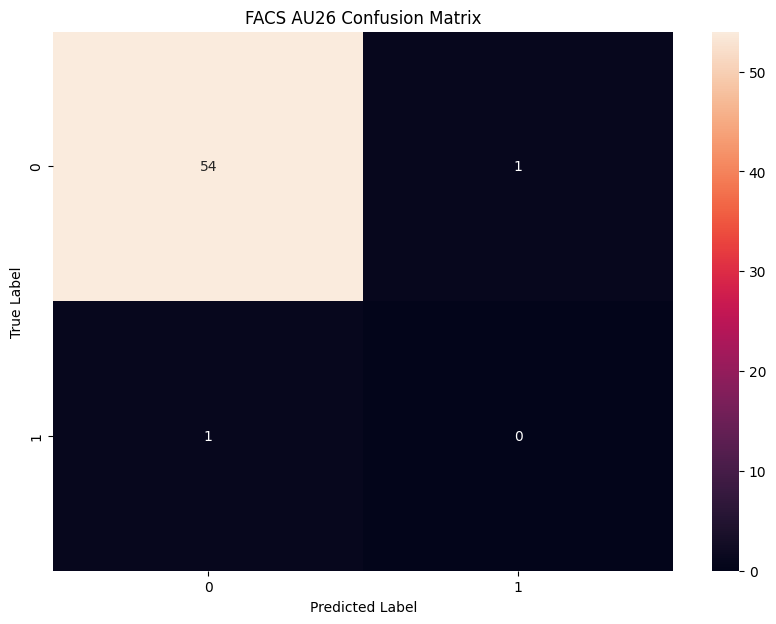

In [42]:
from sklearn.metrics import confusion_matrix

# Generate predictions
(emotion_preds, emotion_true), facs_preds_dict, facs_true_dict = generate_predictions(model, test_loader)


emotion_cm = confusion_matrix(emotion_true.argmax(axis=1), emotion_preds.argmax(axis=1))
plt.figure(figsize=(10, 7))
sns.heatmap(emotion_cm, annot=True, fmt='d')
plt.title('Emotion Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

for au_code in au_codes:
    facs_pred_labels = facs_preds_dict[au_code] > 0.5
    facs_true_labels = facs_true_dict[au_code]
    facs_cm = confusion_matrix(facs_true_labels, facs_pred_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(facs_cm, annot=True, fmt='d')
    plt.title(f'FACS {au_code} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [43]:
from sklearn.metrics import classification_report

In [44]:
emotion_report = classification_report(emotion_true.argmax(axis=1), emotion_preds.argmax(axis=1), target_names=['negative', 'positive', 'surprise'])
print("Emotion Classification Report:\n", emotion_report)

Emotion Classification Report:
               precision    recall  f1-score   support

    negative       0.78      0.94      0.85        33
    positive       0.86      0.50      0.63        12
    surprise       0.89      0.73      0.80        11

    accuracy                           0.80        56
   macro avg       0.84      0.72      0.76        56
weighted avg       0.81      0.80      0.79        56



In [45]:
for au_code in au_codes:
    facs_pred_labels = facs_preds_dict[au_code] > 0.5
    facs_true_labels = facs_true_dict[au_code]
    facs_report = classification_report(facs_true_labels, facs_pred_labels)
    print(f"FACS {au_code} Classification Report:\n", facs_report)


FACS AU17 Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.97      0.70        31
           1       0.00      0.00      0.00        25

    accuracy                           0.54        56
   macro avg       0.27      0.48      0.35        56
weighted avg       0.30      0.54      0.39        56

FACS AU1 Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.85        41
           1       1.00      0.07      0.12        15

    accuracy                           0.75        56
   macro avg       0.87      0.53      0.49        56
weighted avg       0.81      0.75      0.66        56

FACS AU2 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88        45
           1       0.00      0.00      0.00        11

    accuracy                           0.79        56
   macro avg       0.40     

In [46]:
pred_facs

[['AU2', 'AU25', 'AU27', 'AU6', 'AU12', 'AU11'],
 ['AU1', 'AU2', 'AU27', 'AU15', 'AU14'],
 ['AU1', 'AU2', 'AU25', 'AU12', 'AU15', 'AU11'],
 ['AU25', 'AU4', 'AU7', 'AU23', 'AU6', 'AU12', 'AU11', 'AU26'],
 ['AU1', 'AU2', 'AU25', 'AU27', 'AU11', 'AU26'],
 ['AU1', 'AU2', 'AU27', 'AU7', 'AU24', 'AU6'],
 ['AU2', 'AU25', 'AU7', 'AU11'],
 ['AU1', 'AU2', 'AU25', 'AU12', 'AU15', 'AU11'],
 ['AU2', 'AU25', 'AU15', 'AU14', 'AU11', 'AU26'],
 ['AU2', 'AU25', 'AU6', 'AU11', 'AU26'],
 ['AU2', 'AU25', 'AU27', 'AU23', 'AU12', 'AU14', 'AU26'],
 ['AU1', 'AU2', 'AU27', 'AU7', 'AU24'],
 ['AU1', 'AU2', 'AU25', 'AU15', 'AU11', 'AU26'],
 ['AU25', 'AU27', 'AU7', 'AU6'],
 ['AU1', 'AU2', 'AU15', 'AU14', 'AU26'],
 ['AU25', 'AU4', 'AU7', 'AU23', 'AU6', 'AU11', 'AU26'],
 ['AU1', 'AU2', 'AU25', 'AU12', 'AU15', 'AU11'],
 ['AU2', 'AU25', 'AU6', 'AU12', 'AU15', 'AU11', 'AU26'],
 ['AU25', 'AU4', 'AU7', 'AU11', 'AU26'],
 ['AU2', 'AU25', 'AU27', 'AU23', 'AU24', 'AU6', 'AU12', 'AU26'],
 ['AU1', 'AU2', 'AU25', 'AU12', 'AU15',

In [47]:
pred_emotions

['negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'surprise',
 'negative',
 'negative',
 'surprise',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'negative',
 'negative',
 'surprise',
 'surprise',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'surprise',
 'negative',
 'surprise',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'surprise',
 'negative',
 'negative',
 'negative',
 'surprise',
 'positive',
 'negative',
 'negative',
 'negative',
 'surprise',
 'positive']